# Gradient Approach

In [30]:
from matplotlib import pyplot as plt
from utils.edge_extraction import extract_working_region
import cv2
from utils.feature_extraction import *
from utils.image_conversion import *

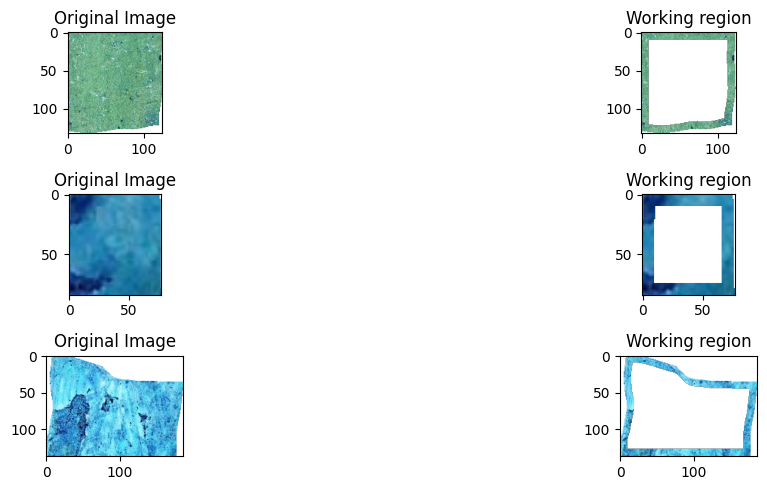

In [31]:
image_green1 = cv2.imread("data/data/5.34.1.png", cv2.IMREAD_UNCHANGED)
image_green2 = cv2.imread("data/data/5.38.15.png", cv2.IMREAD_UNCHANGED)
image_yellow = cv2.imread("data/data/5.34.34.png", cv2.IMREAD_UNCHANGED)

working_region_image_green1 = extract_working_region(image_green1, threshold=10)
working_region_image_green2 = extract_working_region(image_green2, threshold=10)
working_region_image_yellow = extract_working_region(image_yellow, threshold=10)

fig, axes = plt.subplots(3, 2, figsize=(15, 5))
images = [image_green1, working_region_image_green1, image_green2, working_region_image_green2, image_yellow, working_region_image_yellow]
titles = ["Original Image", "Working region"]

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(images[i * 2 + j])
        ax.set_title(titles[j])

plt.tight_layout()
plt.show()

In [32]:
def get_only_valid_pixels(input_image: np.ndarray) -> np.ndarray:
    # Extract pixels with alpha channel value different from 0
    valid_pixels = input_image[input_image[:, :, 3] != 0]

    # Reshape to (num_pixels, 4)
    reshaped_image = valid_pixels.reshape((-1, 4))

    # Determine the dimensions of the reshaped image
    num_pixels = reshaped_image.shape[0]
    width = int(np.sqrt(num_pixels))
    height = (num_pixels + width - 1) // width

    # Pad the reshaped image to make it rectangular
    padded_image = np.zeros((height * width, 4), dtype=np.uint8)
    padded_image[:num_pixels, :] = reshaped_image

    # Reshape the padded image to the desired dimensions
    final_image = padded_image.reshape((height, width, 4))

    # Split channel
    b, g, r, a = cv2.split(final_image)
    rgb_image = cv2.merge((b, g, r))

    return rgb_image

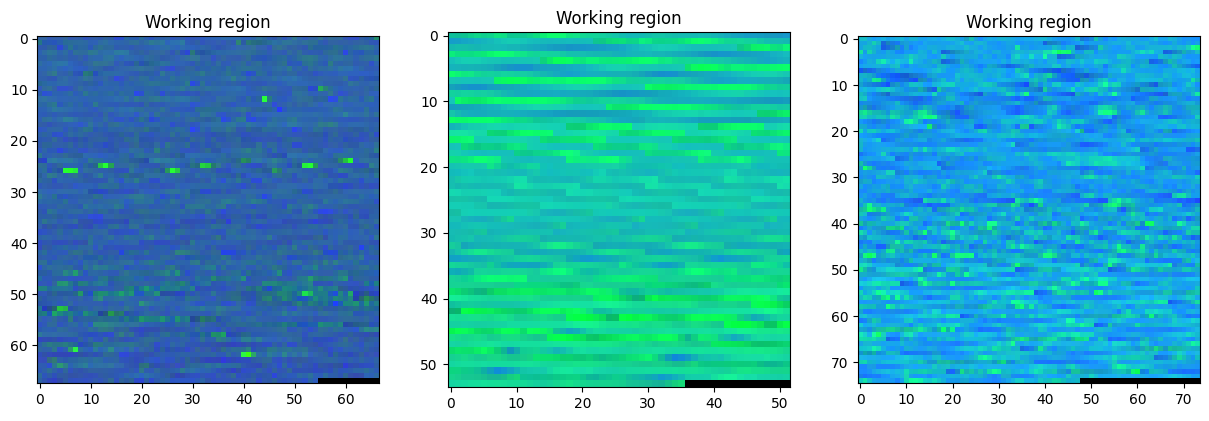

In [33]:
working_region_image_green1 = get_only_valid_pixels(working_region_image_green1)
working_region_image_green2 = get_only_valid_pixels(working_region_image_green2)
working_region_image_yellow = get_only_valid_pixels(working_region_image_yellow)

working_region_image_green1 = cv.cvtColor(working_region_image_green1, cv.COLOR_BGR2HSV)
working_region_image_green2 = cv.cvtColor(working_region_image_green2, cv.COLOR_BGR2HSV)
working_region_image_yellow = cv.cvtColor(working_region_image_yellow, cv.COLOR_BGR2HSV)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
images = [working_region_image_green1, working_region_image_green2,working_region_image_yellow]
titles = ["Working region"]

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(titles[0])

plt.show()

In [34]:
jacobian = compute_image_gradient(working_region_image_yellow[:,:,:3])
jacobian

TypeError: object of type 'int' has no len()